# Instructions

We pull data from the Weights & Biases API and generate plots. Plots can be combined together into a multi-panel figures manually in Keynote for best control over arrangement (see `notebooks/paper/figure_panels.key`). The documentation for the Weights & Biases API function that fetches runs can be found [here](https://docs.wandb.ai/ref/python/public-api/api#runs), but you shouldn't need it if you use the helper functions below.

In [1]:
from typing import Literal, Any
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import wandb

# Style for making nice-looking paper plots with page-scale figure size units
sns.set(
    style="ticks",
    context="paper",
    rc={
        "font.size": 6,
        "axes.titlesize": 7,
        "axes.labelsize": 7,
        "axes.labelpad": 2,
        "xtick.labelsize": 5,
        "ytick.labelsize": 5,
        "legend.title_fontsize": 5.5,
        "legend.fontsize": 5.5,
        "legend.markerscale": 0.5,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.linewidth": 0.4,
        "xtick.major.width": 0.4,
        "ytick.major.width": 0.4,
        "xtick.major.size": 2.5,
        "ytick.major.size": 2.5,
        "xtick.minor.size": 1.5,
        "ytick.minor.size": 1.5,
        "xtick.minor.width": 0.2,
        "ytick.minor.width": 0.2,
        "figure.constrained_layout.use": True,
        "figure.dpi": 200,
    },
)

api = wandb.Api()

# Helper functions

In [36]:
# API querying


def get_run_performances(
    wandb_username: str,
    dataset: str,
    compare_across: list[str],
    comparison_metrics: list[str],  # Note, first one is used for selecting best epoch
    filters: dict[str, Any],
    best_epoch: bool = True,
    mode: Literal["min", "max"] = "max",
    group_comparison: Literal["mean", "median"] = "mean",
    save_path: str = None,
) -> pd.DataFrame:
    # If data has already been downloaded, don't make another API call
    if os.path.exists(save_path):
        return pd.read_csv(save_path)

    # Fetch all run data from the API
    runs = api.runs(
        f"{wandb_username}/Explicit-Implicit",
        filters={"config.dataset": dataset, **filters},
    )

    # Collect all of the run histories into a dataframe
    data = []
    for run in runs:
        comparison_vals = {k: run.config[k] for k in compare_across}
        run_data = run.history(samples=1000000, x_axis="epoch", keys=comparison_metrics)
        run_data = run_data.assign(**comparison_vals)
        data.append(run_data)
    data = pd.concat(data)

    # For each candidate, find the best performance over the course of training.
    # If there are multiple runs with the same `compare_across` values (e.g., different seeds),
    # then we take the best aggregate performance.
    if best_epoch:
        # fmt: off
        def best_epoch_results(group_data):
            epoch_agg = group_data.groupby("epoch")[comparison_metrics[0]].agg(group_comparison)
            best_epoch = epoch_agg.argmax() if mode == "max" else epoch_agg.argmin()
            best_epoch_data = group_data[group_data["epoch"] == best_epoch]
            return best_epoch_data
        data = data.groupby(compare_across).apply(best_epoch_results)
        data = data.reset_index(drop=True)
        # fmt: on

    if save_path is not None:
        data.to_csv(save_path, index=False)
    return data


# Plotting


default_model_order = [
    "implicit",
    "explicit-transformer",
    "explicit-mlp",
    "explicit-known",
]
default_model_colours = {
    "implicit": sns.color_palette()[7],
    "explicit-transformer": sns.color_palette()[0],
    "explicit-mlp": sns.color_palette()[1],
    "explicit-known": sns.color_palette()[2],
}
default_model_short_names = {
    "implicit": "Implicit",
    "explicit-transformer": "Explicit - Transformer",
    "explicit-mlp": "Explicit - MLP",
    "explicit-known": "Explicit - Known",
}


def model_comparison_barplot(
    data: pd.DataFrame,
    metrics: str | list[str],
    metric_short_names: dict[str, str],
    metric_units: str,
    ax: plt.Axes,
    model_order: list[str] = default_model_order,
    model_colours: dict[str, Any] = default_model_colours,
    model_short_names: dict[str, str] = default_model_short_names,
    errorbar: str = "minmax",
    **kwargs,
):
    # Check argument correctness
    models = data["model"].unique()
    for m in models:
        assert m in model_order and m in model_colours and m in model_short_names
    model_order = [m for m in model_order if m in models]
    if isinstance(metrics, str):
        metrics = [metrics]
    errorbar = (lambda x: (x.min(), x.max())) if errorbar == "minmax" else errorbar

    # Reorganize data
    data = data.rename(columns={m: metric_short_names[m] for m in metrics})
    data["model"] = data["model"].map(model_short_names)
    model_colours = [model_colours[m] for m in model_order]
    model_order = [model_short_names[m] for m in model_order]
    data = data.melt(
        id_vars=["model"],
        value_vars=metric_short_names.values(),
        var_name="metric",
        value_name=metric_units,
    )

    # Make the plot
    sns.barplot(
        data=data,
        ax=ax,
        x="metric",
        y=metric_units,
        hue="model",
        hue_order=model_order,
        palette=model_colours,
        errorbar=errorbar,
        **kwargs,
    )
    ax.set(xlabel="")
    ax.legend()

    return ax

# Raven's Progressive Matrices

### Model comparison

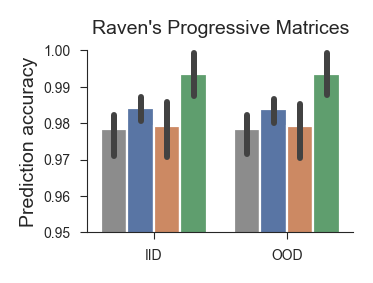

In [3]:
data = get_run_performances(
    wandb_username="ericelmoznino",
    dataset="raven",
    compare_across=["model"],
    comparison_metrics=["val_iid/accuracy", "val_ood/accuracy"],
    filters={
        "config.setting": "inpo",
        "tags": {
            "$nin": ["implicit_sweep", "explicit_tsf_sweep", "explicit_mlp_sweep"]
        },
    },
    save_path="data/raven_model_comparison.csv",
)

fig, ax = plt.subplots(figsize=(1.75, 1.3))
model_comparison_barplot(
    data=data,
    metrics=["val_iid/accuracy", "val_ood/accuracy"],
    metric_short_names={"val_iid/accuracy": "IID", "val_ood/accuracy": "OOD"},
    metric_units="Prediction accuracy",
    ax=ax,
)
ax.set(ylim=(0.95, 1.0), title="Raven's Progressive Matrices")
ax.legend(loc="upper right").remove()
fig.savefig("saved/raven_model_comparison.pdf")
plt.show()

### Rule decoding

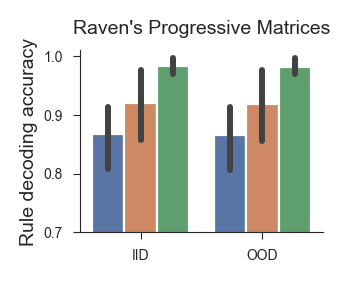

In [12]:
data = get_run_performances(
    wandb_username="ericelmoznino",
    dataset="raven",
    compare_across=["model"],
    comparison_metrics=["val_iid/rule_accuracy", "val_ood/rule_accuracy"],
    filters={
        "config.setting": "inpo",
        "tags": {
            "$nin": ["implicit_sweep", "explicit_tsf_sweep", "explicit_mlp_sweep"]
        },
    },
    save_path="data/raven_rule_decoding.csv",
)

fig, ax = plt.subplots(figsize=(1.6, 1.3))
model_comparison_barplot(
    data=data,
    metrics=["val_iid/rule_accuracy", "val_ood/rule_accuracy"],
    metric_short_names={"val_iid/rule_accuracy": "IID", "val_ood/rule_accuracy": "OOD"},
    metric_units="Rule decoding accuracy",
    ax=ax,
)
ax.set(ylim=(0.7, 1.01), title="Raven's Progressive Matrices")
ax.legend(loc="upper right").remove()
fig.savefig("saved/raven_rule_decoding.pdf")
plt.show()

# Gene targeting

### Model comparison

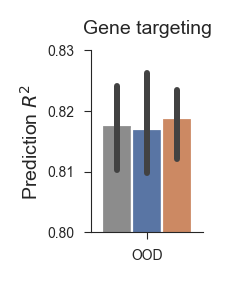

In [26]:
data = get_run_performances(
    wandb_username="ericelmoznino",
    dataset="gene_crispr",
    compare_across=["model"],
    comparison_metrics=["val/R2"],
    filters={
        "config.model": {
            "$in": [
                "implicit-dropout",
                "explicit-transformer-dropoutcontext",
                "explicit-mlp",
            ]
        },
    },
    save_path="data/gene_model_comparison.csv",
)
data["model"] = data["model"].replace(
    {
        "implicit-dropout": "implicit",
        "explicit-transformer-dropoutcontext": "explicit-transformer",
    }
)

fig, ax = plt.subplots(figsize=(1, 1.3))
model_comparison_barplot(
    data=data,
    metrics="val/R2",
    metric_short_names={"val/R2": "OOD"},
    metric_units=r"Prediction $R^2$",
    ax=ax,
)
ax.set(ylim=(0.8, 0.83), title="Gene targeting", yticks=[0.8, 0.81, 0.82, 0.83])
ax.legend(loc="upper right").remove()
fig.savefig("saved/gene_model_comparison.pdf")
plt.show()

### CRISPR target decoding

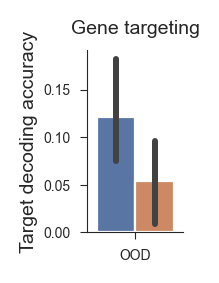

In [33]:
data = get_run_performances(
    wandb_username="ericelmoznino",
    dataset="gene_crispr",
    compare_across=["model"],
    comparison_metrics=["val/ptb_id_acc"],
    filters={
        "config.model": {
            "$in": [
                "explicit-transformer-dropoutcontext",
                "explicit-mlp",
            ]
        },
    },
    save_path="data/gene_target_decoding.csv",
)
data["model"] = data["model"].replace(
    {"explicit-transformer-dropoutcontext": "explicit-transformer"}
)

fig, ax = plt.subplots(figsize=(0.9, 1.3))
model_comparison_barplot(
    data=data,
    metrics="val/ptb_id_acc",
    metric_short_names={"val/ptb_id_acc": "OOD"},
    metric_units="Target decoding accuracy",
    ax=ax,
)
ax.set(title="Gene targeting")
ax.legend(loc="upper right").remove()
fig.savefig("saved/gene_target_decoding.pdf")
plt.show()

# Sinusoidal regression

### Model comparison - Fixed frequency - 3 frequencies

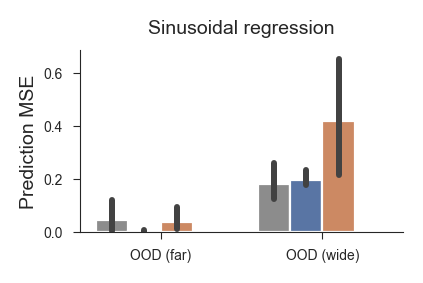

In [48]:
data = get_run_performances(
    wandb_username="ericelmoznino",
    dataset="sinusoid-regression",
    compare_across=["model"],
    comparison_metrics=["val/iid_MSE", "val/far_MSE", "val/wide_MSE"],
    mode="min",
    filters={
        "config.model": {"$nin": ["explicit-transformer-known-context"]},
        "config.kind_kwargs": "{'fixed_freq': True, 'n_freq': 3}",
    },
    save_path="data/sinusoid_model_comparison.csv",
)

fig, ax = plt.subplots(figsize=(2, 1.3))
model_comparison_barplot(
    data=data,
    metrics=["val/far_MSE", "val/wide_MSE"],
    metric_short_names={"val/far_MSE": "OOD (far)", "val/wide_MSE": "OOD (wide)"},
    metric_units="Prediction MSE",
    ax=ax,
)
ax.set(title="Sinusoidal regression")
ax.legend(loc="upper right").remove()
fig.savefig("saved/sinusoid_model_comparison.pdf")
plt.show()

### $W$ decoding - Fixed frequency - 3 frequencies

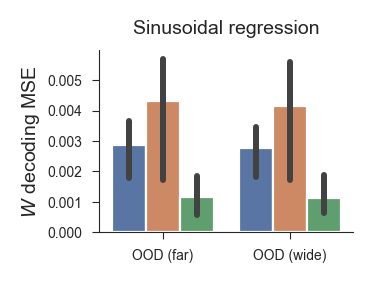

In [49]:
data = get_run_performances(
    wandb_username="ericelmoznino",
    dataset="sinusoid-regression",
    compare_across=["model"],
    comparison_metrics=["val/iid_w_loss", "val/far_w_loss", "val/wide_w_loss"],
    mode="min",
    filters={
        "config.model": {"$nin": ["implicit", "explicit-transformer-known-context"]},
        "config.kind_kwargs": "{'fixed_freq': True, 'n_freq': 3}",
    },
    save_path="data/sinusoid_w_decoding.csv",
)

fig, ax = plt.subplots(figsize=(1.75, 1.3))
model_comparison_barplot(
    data=data,
    metrics=["val/far_w_loss", "val/wide_w_loss"],
    metric_short_names={"val/far_w_loss": "OOD (far)", "val/wide_w_loss": "OOD (wide)"},
    metric_units=r"$W$ decoding MSE",
    ax=ax,
)
ax.set(title="Sinusoidal regression")
ax.legend(loc="upper right").remove()
fig.savefig("saved/sinusoid_w_decoding.pdf")
plt.show()